## Week 5-1: Unsupervised learning

#### Announcement
* Final project guidelines posted

#### Last time
* Confusion matrix and ROC curve
* Support vector machine

#### Today
* Loss function
* K-means 
* Gaussian mixture model

#### Reference
- James Sharpnack's lecture notes 
- Ch 13&14 of ESL
- M. Emre Celebi, Hassan A. Kingravi and Patricio A. Vela (2013). A comparative study of efficient initialization methods for the k-means clustering algorithm. _Expert Systems with Applications_ 40:200--210
- A. P. Dempster, N. M. Laird and D. B. Rubin (1977). Maximum Likelihood from Incomplete Data via the EM Algorithm. _JRSSB_ 39:1--38


### Loss function

#### 0-1 loss

We can rewrite the 0-1 loss for a linear classifier as
$$
\ell_{0/1}(\beta,x_i,y_i) = 1 \{ y_i \beta^\top x_i < 0 \}.
\tag{0-1 loss}
$$

#### Loss function for logistic regression 

Logistic regression uses a loss function that mimics some of the behavior of the 0-1 loss, but is not discontinuous. So, it is a _surrogate loss_, which will make our life easier. 

The logistic loss is a function of $y_i \beta^\top x_i$, which is 
$$
\ell_{L} (\beta, x_i, y_i) = \log(1 + \exp(-y_i \beta^\top x_i)).
\tag{logistic}
$$

#### Loss function for SVM  
SVM uses a hinge loss 
$$
\ell_{H} (\beta, x_i, y_i) = (1 - y_i \beta^\top x_i)_+
\tag{hinge}
$$
(why?) or $(1 - y_i f(x_i))_+$ in general.
where $a_+ = a 1\{ a > 0\}$ is the positive part of the real number $a$.


#### Squared Hinge loss

If we are free to select training loss functions, then why not square error loss?  For example, we could choose
$$
\ell_{S} (\beta, x_i, y_i) = (y_i - \beta^\top x_i)^2 = (1 - y_i \beta^\top x_i)^2.
\tag{squared hinge error}
$$
In order to motivate the use of these, let's plot the losses as a function of $y_i \beta^\top x_i$.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2022)

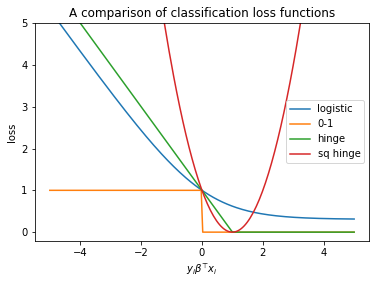

In [2]:
z_range = np.linspace(-5,5,200)
zoloss = z_range < 0
l2loss = (1-z_range)**2.
hingeloss = (1 - z_range) * (z_range < 1)
logisticloss = np.log(1 + np.exp(-z_range))
plt.plot(z_range, logisticloss + 1 - np.log(2.),label='logistic')
plt.plot(z_range, zoloss,label='0-1')
plt.plot(z_range, hingeloss,label='hinge')
plt.plot(z_range, l2loss,label='sq hinge')
plt.ylim([-.2,5])
plt.xlabel(r'$y_i \beta^\top x_i$')
plt.ylabel('loss')
plt.title('A comparison of classification loss functions')
_ = plt.legend()

Comparing these we see that the logistic loss is smooth---it has continuous first and second derivatives---and it is decreasing as $y_i \beta^\top x_i$ is increasing.  The hinge loss is interesting, it is continuous, but it has a discontinuous first derivative.  This changes the nature of optimization algorithms that we will tend to use.  On the other hand the hinge loss is zero for large enough $y_i \beta^\top x_i$, as opposed to the logistic loss which is always non-zero.  Below we depict these two losses by weighting each point by the loss for the fitted classifier.

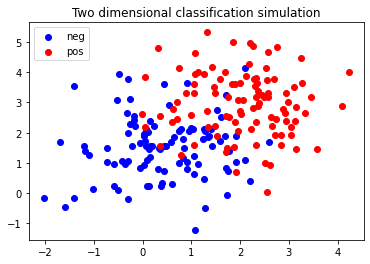

In [3]:
N = 100
def lm_sim(N = N):
    """simulate a binary response and two predictors"""
    X1 = (np.random.randn(N*2)).reshape((N,2)) + np.array([2,3])
    X0 = (np.random.randn(N*2)).reshape((N,2)) + np.array([.5,1.5])
    y = - np.ones(N*2)
    y[:N]=1
    X = np.vstack((X1,X0))
    return X, y, X0, X1
X_sim,y_sim,X0,X1 = lm_sim()
plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
plt.title("Two dimensional classification simulation")
_ = plt.legend(loc=2)

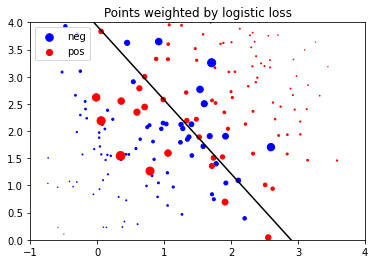

In [4]:
from sklearn import linear_model

lr_sim = linear_model.LogisticRegression()
lr_sim.fit(X_sim,y_sim)

beta1 = lr_sim.coef_[0,0]
beta2 = lr_sim.coef_[0,1]
beta0 = lr_sim.intercept_

mults=0.8
T = np.linspace(-1,4,100)
x2hat = -(beta0 + beta1*T) / beta2

z_log = y_sim*lr_sim.decision_function(X_sim)
logisticloss = np.log(1 + np.exp(-z_log))
plt.scatter(X0[:,0],X0[:,1],s=logisticloss[N:]*30.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=logisticloss[:N]*30.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,4])
plt.ylim([0,4])
plt.title("Points weighted by logistic loss")
_ = plt.legend(loc=2)

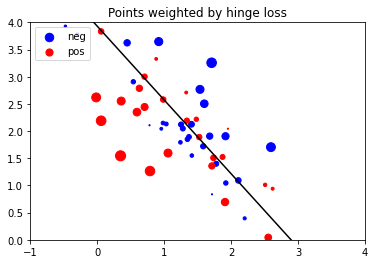

In [5]:
hingeloss = (1-z_log)*(z_log < 1)
plt.scatter(X0[:,0],X0[:,1],s=hingeloss[N:]*30.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=hingeloss[:N]*30.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,4])
plt.ylim([0,4])
plt.title("Points weighted by hinge loss")
_ = plt.legend(loc=2)

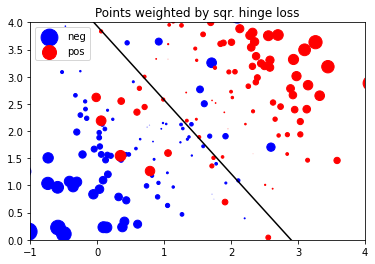

In [6]:
l2loss = (1-z_log)**2.
plt.scatter(X0[:,0],X0[:,1],s=l2loss[N:]*10.,c='b',label='neg')
plt.scatter(X1[:,0],X1[:,1],s=l2loss[:N]*10.,c='r',label='pos')
plt.plot(T,x2hat,c='k')
plt.xlim([-1,4])
plt.ylim([0,4])
plt.title("Points weighted by sqr. hinge loss")
_ = plt.legend(loc=2)

We see that for the logistic loss the size is vanishing when the points are on the wrong side of the separator hyperplane.  The hinge loss is zero if we are sufficiently far from the hyperplane.  The square hinge error loss has increased weight for those far from the hyperplane, even if they are correctly classified.  Hence, __squared hinge error loss is not a good surrogate for 0-1 loss.__

### K-means clustering algorithm



K-means clustering is a method for finding clusters and cluster centers in a set of unlabeled data. One choose the desired number of cluster centers, and the K-means procedure iteratively move the centers to minimize the total within cluster variance. 

Define the squared Euclidean distance as 
$$
d(x_i, x_{i'}) = \sum_{j = p}^p (x_{ij} - x_{i'j})^2 = \|x_i - x_{i'}\|^2
$$

Then _within-point scatter_ can be written as
\begin{align}
W(C) & = \frac{1}{2} \sum_{k = 1}^K \sum_{C(i) = k} \sum_{C(i') = k} \|x_i - x_{i'}\|^2\\
     & = \sum_{k=1}^K N_k \sum_{C(i) = k} \|x_i - \bar x_k\|^2,
\end{align}
where $N_k = \sum_{i=1}^N I(C(i) = k)$.

#### Iterative method for K-means clustering:

1. Given a cluster assignment $C$, 
$$
\{m_k\}_{k = 1}^K = \min_{\{m_k\}} \sum_{k=1}^K N_k \sum_{C(i) = k} \|x_i - m_k\|^2
$$

2. Given a current set of means $\{m_1, \dots, m_K\}$, obtain 
$$
C^\star = \min_C\sum_{k=1}^K N_k \sum_{C(i) = k} \|x_i - \bar x_k\|^2
$$

3. Repeat 1 and 2 until the assignments do not change

In [2]:
import numpy as np
import pandas as pd

mouse = pd.read_csv('mouse.csv', sep = " ", header = None)

In [3]:
mouse.shape

(490, 3)

In [4]:
# separate to head, ear left, and ear right
mouse_head = mouse[mouse[2] == "Head"]
mouse_EL = mouse[mouse[2] == "Ear_left"]
mouse_ER = mouse[mouse[2] == "Ear_right"]

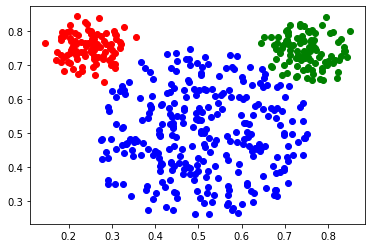

In [7]:
# plot data

plt.scatter(mouse_head[0], mouse_head[1],c='b',label='H')
plt.scatter(mouse_EL[0], mouse_EL[1], c='r',label='EL')
plt.scatter(mouse_ER[0], mouse_ER[1], c='g',label='RL')

In [13]:
# fit K-means with three clusters

X = np.array([mouse[0], mouse[1]])

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state=0).fit(np.transpose(X))

In [14]:
kmeans_pred = kmeans.predict(np.transpose(X))

In [15]:
mouse_pred = np.transpose(np.array([mouse[0], mouse[1], kmeans_pred]))

In [16]:
mouse_head_pred = mouse_pred[mouse_pred[:, 2] == 0]
mouse_EL_pred = mouse_pred[mouse_pred[:, 2] == 1]
mouse_ER_pred = mouse_pred[mouse_pred[:, 2] == 2]

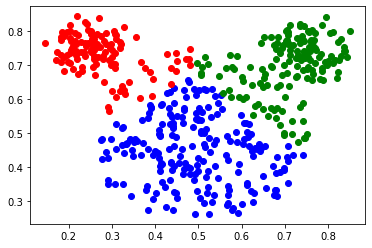

In [17]:
# plot data with predicted label

plt.scatter(mouse_head_pred[:, 0], mouse_head_pred[:, 1],c='b',label=0)
plt.scatter(mouse_EL_pred[:,0], mouse_EL_pred[:,1], c='r',label=1)
plt.scatter(mouse_ER_pred[:,0], mouse_ER_pred[:,1], c='g',label=2)

Try if changing the number of clusters a different number. 

Impletement K-means by yourself? Sample code [here](https://jonchar.net/notebooks/k-means/#:~:text=k%2Dmeans%20clustering%3A%20An%20example,user%20before%20starting%20the%20algorithm.)

Issues with K-means? 
- Choose $K$ manually
- Depends on initial values (Celebi, Kingravi, and Vela, 2013)
- Cluster data of varying size and density
- Outliers
- Curse of dimensionality

### Gaussian mixture model

See notes for the GM model

In [120]:
from sklearn.mixture import GaussianMixture

GM = GaussianMixture(n_components=3, random_state=0).fit(np.transpose(X))

In [122]:
GM_predict = GM.predict(np.transpose(X))

In [123]:
mouse_GM_pred = np.transpose(np.array([mouse[0], mouse[1], GM_predict]))
mouse_head_GM_pred = mouse_GM_pred[mouse_GM_pred[:, 2] == 0]
mouse_EL_GM_pred = mouse_GM_pred[mouse_GM_pred[:, 2] == 1]
mouse_ER_GM_pred = mouse_GM_pred[mouse_GM_pred[:, 2] == 2]

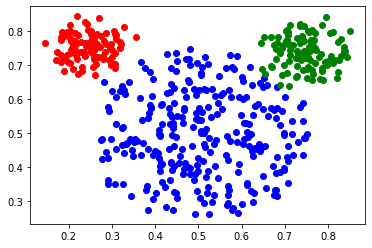

In [124]:
# plot data with predicted label

plt.scatter(mouse_head_GM_pred[:, 0], mouse_head_GM_pred[:, 1],c='b',label=0)
plt.scatter(mouse_EL_GM_pred[:,0], mouse_EL_GM_pred[:,1], c='r',label=1)
plt.scatter(mouse_ER_GM_pred[:,0], mouse_ER_GM_pred[:,1], c='g',label=2)

EM algorithm for Gaussian mixture model

See notes